In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(4, 64)
        self.dense2 = nn.Linear(64, 2)

        nn.init.zeros_(self.dense1.bias)
        nn.init.zeros_(self.dense2.bias)
        
        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='relu')
        with torch.no_grad():
            self.dense2.weight *= 0.1

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.softmax(self.dense2(x), dim=1)
        return x

In [80]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

EPISODES = 4000

env = gym.make("CartPole-v1", render_mode="rgb_array")

policy = Model()
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

discount = 0.99
losses = []
rewards = []
max_reward = 0

for e in range(EPISODES):
    observation, info = env.reset()

    log_probs = []
    episode_rewards = []
    total_episode_reward = 0

    episode_over = False
    while not episode_over:

        state = torch.from_numpy(observation).view(1, -1)

        # action = env.action_space.sample()  # agent policy that uses the observation and info
        probs = policy(state)
        action = torch.multinomial(probs, num_samples=1).item()
        observation, reward, terminated, truncated, info = env.step(action)

        log_probs.append(torch.log(probs[0, action]))
        episode_rewards.append(reward)
        total_episode_reward += reward

        episode_over = terminated or truncated
    
    rewards.append(total_episode_reward)
    if total_episode_reward > max_reward:
        max_reward = total_episode_reward
        print(f"New max of {max_reward} in episode {e + 1}")

    returns = []
    R = 0
    for r in reversed(episode_rewards):
        R = r + discount * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    loss = 0
    optimizer.zero_grad()
    for log_prob, R in zip(log_probs, returns):
        loss += -log_prob * R
        
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    losses.append(loss.item())

    if (e + 1) % 500 == 0:
        print(f"Episodes {(e - 499, e)}: Avg Loss- {sum(losses[e-499:e+1])/500}, Avg Return- {sum(rewards[e-499:e+1])/500}")
        
env.close()

New max of 16.0 in episode 1
New max of 82.0 in episode 2
New max of 105.0 in episode 100
New max of 110.0 in episode 129
New max of 111.0 in episode 135
New max of 120.0 in episode 140
New max of 167.0 in episode 153
New max of 175.0 in episode 184
New max of 240.0 in episode 191
New max of 241.0 in episode 240
New max of 266.0 in episode 245
New max of 313.0 in episode 248
New max of 323.0 in episode 302
New max of 329.0 in episode 305
New max of 341.0 in episode 323
New max of 416.0 in episode 346
New max of 468.0 in episode 407
New max of 482.0 in episode 414
New max of 498.0 in episode 415
New max of 500.0 in episode 419
Episodes (0, 499): Avg Loss- -1.5041765656471253, Avg Return- 141.282
Episodes (500, 999): Avg Loss- -3.113993576079607, Avg Return- 329.422
Episodes (1000, 1499): Avg Loss- -2.9661052666306498, Avg Return- 431.394
Episodes (1500, 1999): Avg Loss- -2.8777346423864363, Avg Return- 438.16
Episodes (2000, 2499): Avg Loss- -1.9154480222463608, Avg Return- 426.786
Epis

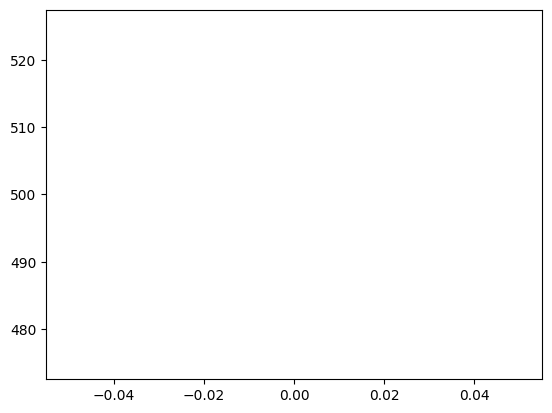

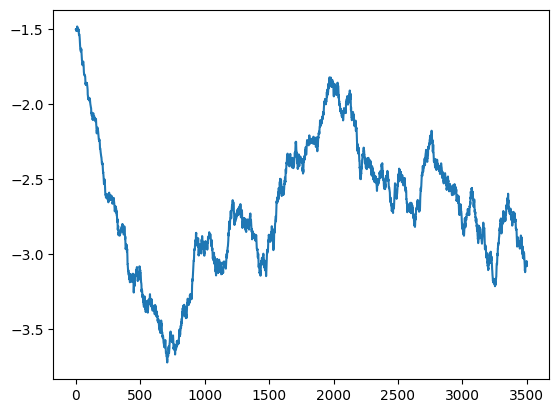

In [90]:
import numpy as np

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, 500))
plt.figure()
plt.plot(moving_average(losses, 500))

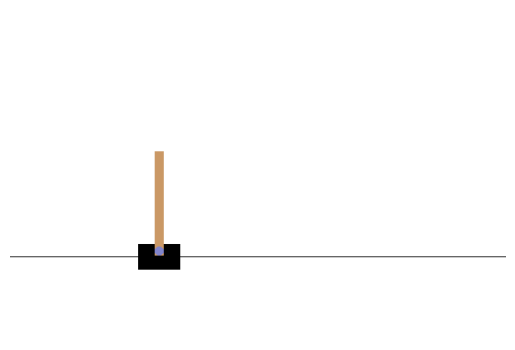

Final Return: 500.0
Average Return over 500 episodes: 500.0


In [82]:
show = True
rewards = []

for _ in range(500):
    observation, info = env.reset()
    episode_reward = 0
    episode_over = False
    while not episode_over:
        if show:
            frame = env.render()
            clear_output(wait=True)
            plt.imshow(frame)
            plt.axis('off')
            plt.show()
            time.sleep(0.002)

        with torch.no_grad():
            probs = policy(torch.from_numpy(observation).view(-1, 4))
            action = torch.argmax(probs, dim=1).item()

        observation, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward

        episode_over = terminated or truncated

    if show:
        show = False
        print(f"Final Return: {episode_reward}")

    rewards.append(episode_reward)

print(f"Average Return over 500 episodes: {sum(rewards) / 500}")

env.close()

In [ ]:
torch.save(policy.state_dict(), f"models/cart_pole/REINFORCE_500")